# Práctica 4 de IA

## 3. Procesamiento de texto y datos no balanceados (3 puntos)

In [8]:
import pandas as pd

df = pd.read_csv("train.tsv", sep='\t', index_col="PhraseId")
pd.set_option('display.max_colwidth', None)
df.head(2)

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
2,1,A series of escapades demonstrating the adage that what is good for the goose,2


Este conjunto de datos que usaremos ahora permite aprender el sentimiento del texto a partir de frases etiquetadas.
Las etiquetas para los sentimientos son:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

Más información [aquí](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews).


A lo largo de este ejercicio veremos distintas formas de procesar el texto y de equilibrar las clases a aprender.

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df[["Phrase", "Sentiment"]], random_state=0)
X_train = train.Phrase
X_test = test.Phrase
y_train = train.Sentiment
y_test = test.Sentiment

**Modelos básicos**

Vamos a comenzar con una concatenación (*pipe*) de modelos muy básicos y analizaremos si tienen algún problema.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

count_vectorizer = CountVectorizer(max_features=1000)
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2)
pipe = make_pipeline(count_vectorizer,decision_tree)

In [11]:
from sklearn.metrics import accuracy_score

def get_accuracy(pipe):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return round(accuracy_score(y_pred, y_test),3)

In [12]:
get_accuracy(pipe)

0.515

Veamos qué clases se están prediciendo de verdad

In [13]:
# Etiquetas de entrenamiento
round(pd.Series(y_train).value_counts(normalize=True),2)

2    0.51
3    0.21
1    0.17
4    0.06
0    0.04
Name: Sentiment, dtype: float64

In [14]:
# Clases en predicción
y_pred = pipe.predict(X_test)
round(pd.Series(y_pred).value_counts(normalize=True),2)

2    0.97
3    0.03
dtype: float64

Es decir: al ser un problema no balanceado, la predicción está claramente sesgada hacia una de las clases.

Esto se puede ver también analizando la **matriz de confusión**

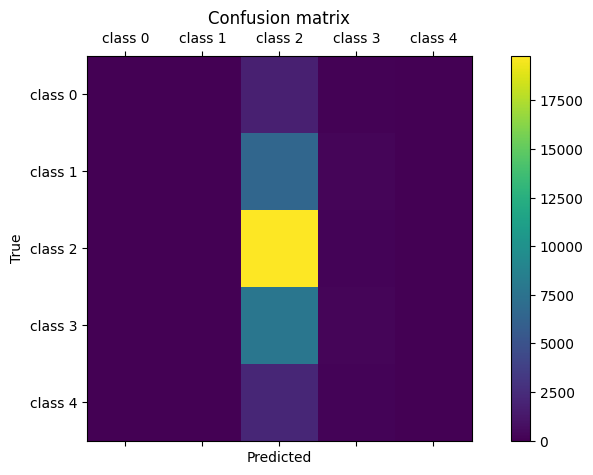

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(pipe):
    ticks = np.unique(y_test)
    labels = [('class '+ str(tick)) for tick in ticks]
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(pipe)

## Cambio de modelos y procesamiento de los datos

Analiza si algún otro modelo de los vistos en ejercicios anteriores evita este problema de las clases desbalanceadas.

Por ejemplo, en la celda siguiente se cambia el árbol de decisión por un KNN.

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
pipe_knn = make_pipeline(count_vectorizer,knn)
get_accuracy(pipe_knn)

0.564

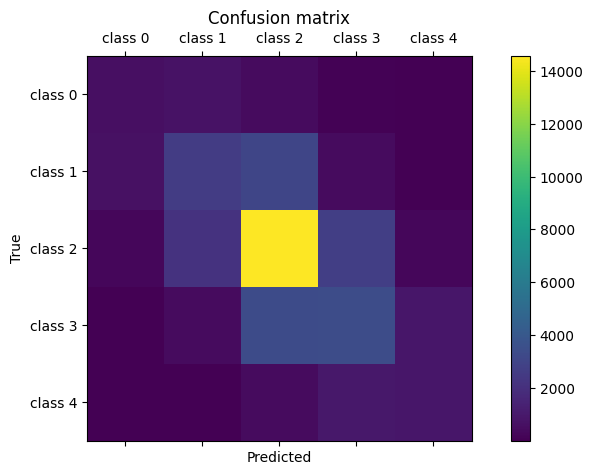

In [17]:
plot_confusion_matrix(pipe_knn)

### Explora varios modelos y responde:

In [18]:
knn2 = KNeighborsClassifier(n_neighbors=10)
pipe_knn2 = make_pipeline(count_vectorizer, knn2)
get_accuracy(pipe_knn2)


0.564

In [19]:
#weights="distance" -> Obtiene mejores resultados
knn3 = KNeighborsClassifier(n_neighbors=15, weights="distance")
pipe_knn3 = make_pipeline(count_vectorizer, knn3)
get_accuracy(pipe_knn3)


0.589

In [28]:
knn4 = KNeighborsClassifier(n_neighbors=15)
pipe_knn4 = make_pipeline(count_vectorizer, knn4)
get_accuracy(pipe_knn4)


0.56

In [21]:
decision_tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=10)
pipe_tree1 = make_pipeline(count_vectorizer, decision_tree1)
get_accuracy(pipe_tree1)


0.531

In [22]:
#Balanced, se puede ver como no incrementa la precision.
decision_tree2 = DecisionTreeClassifier(
    criterion='entropy', max_depth=20, class_weight="balanced")
pipe_tree2 = make_pipeline(count_vectorizer, decision_tree2)
get_accuracy(pipe_tree2)


0.448

In [23]:
#Unbalanced 
decision_tree3 = DecisionTreeClassifier(
    criterion='entropy', max_depth=20)
pipe_tree3 = make_pipeline(count_vectorizer, decision_tree3)
get_accuracy(pipe_tree3)


0.544

* ¿Con qué modelo se obtienen mejores resultados?
    * **Al principio, KNeighbors con k siendo 1 (0,564) mejoraba el accuracy en comparacion con DecisionTree con depth = 2 (0,515) y depth = 5 (0,521), sin embargo se puede ver como KNeighbors con k = 15 con weights="distance" el accuracy sube a (0,589), con KNeighbors k = 15 (0,56) y k = 10 (0,564).**
    **El mejor modelo resulta ser KNeighbors con k = 15 con weights="distance"**
    
* ¿Hay algún parámetro de los modelos que sea particularmente efectivo en evitar el desbalanceo?
    * **Hay parametros aplicables para KNeighbors, como 'weights' y para DecisionTree hay 'class_weigth'.**
    **Especialmente 'weights'="distance" incrementa considerablemente el accuracy ya que es capaz de subirlo a (0,589) desde (0,56) para k =15 ain empeorar significativamente lso tiempos de ejecución.**
    **Cabe mencionar que, class_weight='balanced', en los árboles de decición, ha reducido el tiempo, aunque empeorando los resultados.**


Nota: incluye tantas celdas como precises para enseñar el código que has usado para responder a estas preguntas.

### Procesamiento de los datos

El primer paso que se usó en el *pipe* anterior es muy simple: sólo cuenta cuántas veces aparece cada término. Además, se ha limitado a un máximo de 1000 dimensiones. Prueba otras formas de procesar el texto y discute las diferencias. 

Como ejemplo, en la celda siguiente se usa un método que considera la frecuencia de los términos ([TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)). La documentación muestra que permite varias configuraciones (eliminar acentos, pasar a minúsculas, realizar otras transformaciones más complejas, quitar palabras comunes, etc.).

0.605


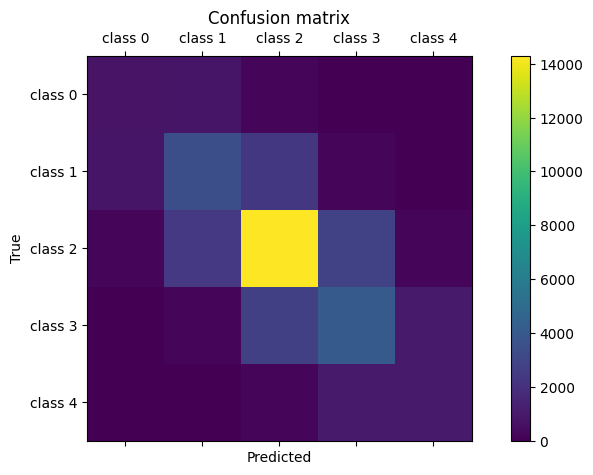

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3))
pipe_tfidf = make_pipeline(tfidf_vectorizer, knn)
print(get_accuracy(pipe_tfidf))
plot_confusion_matrix(pipe_tfidf)

0.606


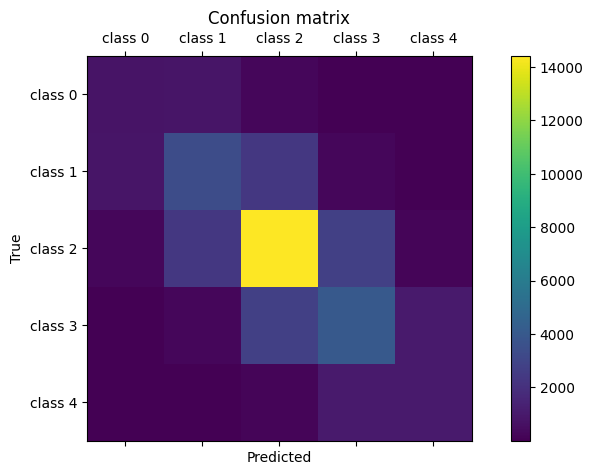

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer2 = TfidfVectorizer(ngram_range=(1, 3))
pipe_tfidf2 = make_pipeline(tfidf_vectorizer2, knn)
print(get_accuracy(pipe_tfidf2))
plot_confusion_matrix(pipe_tfidf2)


0.603


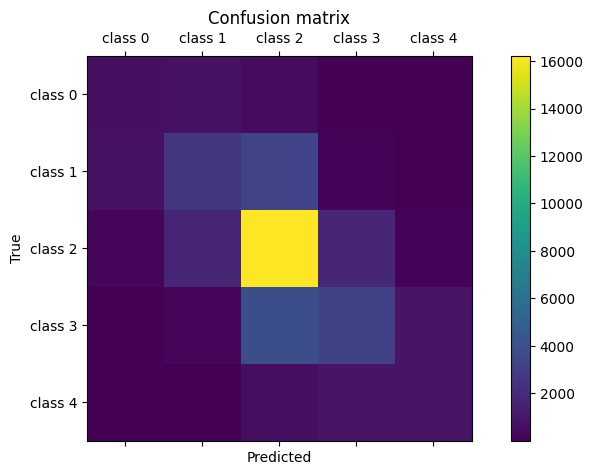

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer2 = TfidfVectorizer(ngram_range=(3, 5))
pipe_tfidf2 = make_pipeline(tfidf_vectorizer2, knn)
print(get_accuracy(pipe_tfidf2))
plot_confusion_matrix(pipe_tfidf2)

0.521


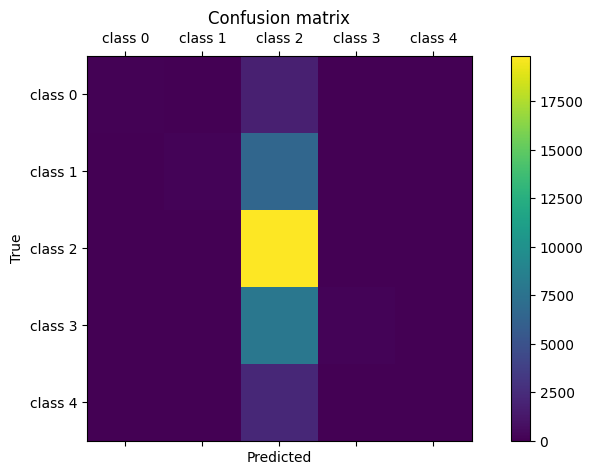

In [26]:
tfidf_vectorizer3 = TfidfVectorizer(ngram_range=(1, 3))
pipe_tfidf3 = make_pipeline(tfidf_vectorizer2, knn3) #Nuestro mejor KNN
print(get_accuracy(pipe_tfidf3))
plot_confusion_matrix(pipe_tfidf3)


0.54


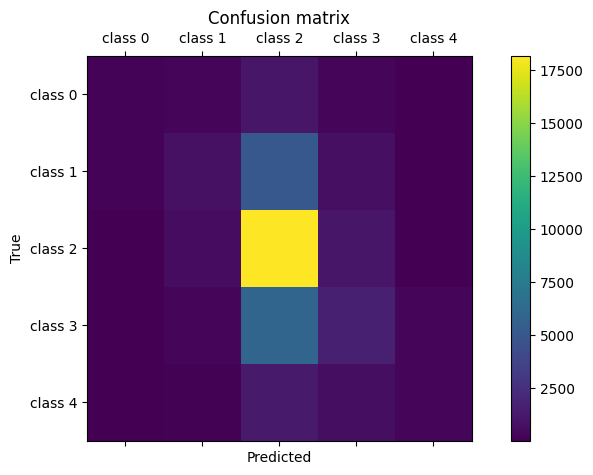

In [29]:
tfidf_vectorizer3 = TfidfVectorizer(ngram_range=(1, 3))
pipe_tfidf3 = make_pipeline(tfidf_vectorizer2, decision_tree3) #Nuestro mejor KNN
print(get_accuracy(pipe_tfidf3))
plot_confusion_matrix(pipe_tfidf3)

Realiza pruebas con varios clasificadores y configuraciones para el procesamiento de texto y contesta:

* De acuerdo con tus experimentos, ¿afecta más cambiar el clasificador o cómo se procesa el texto?
    * **A la vista de los resultados anteriores, hemos comprobado que al cambair el clasificador se ve afectado el procesamiento de texto y por tanto el accuracy. Hemos probado varios tipos de procesamiento de texto, cada uno obteniendo resultados diferentes.**
* ¿Has encontrado algún tipo de procesamiento que siempre mejore los resultados? ¿En qué hipótesis te has basado para probarlo?
    * **El DecisionTree, ya que cuanto mas sofisticado se vuelve, mejores accuracys obtienes.** 

## Conclusiones.
Resume los resultados y conclusiones del estudio que has realizado.



**Esta parte de la practica hemos visto como dependiendo del set de entrenamiento que tengasmos y como sean estos datos, es necesario calibrar bien los algoritmos para poder obtener los mejores resultados. Elegir el algroitmo correcto es tan solo la mitad del proceso, la otra mitad consiste en tunearlo con la configuracion mas optima.**